# Analyze THFR Meta data


For Example: https://hfrportal.moh.go.tz/index.php?r=facilities/view&facility_id=15117


- Uses health facillity from database
- crawls all meta data tables with pandas and saves to CSV, takes quite some time!
- to use extract `thfr_attributes.zip` in notebook directory (compressed for less files in repo…)


In [90]:
from pathlib import Path
import glob
import re

import geopandas
import pandas as pd

# prevent false warning
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

from wordcloud import WordCloud
from collections import Counter

from dbconf import get_engine

In [6]:
hfrdf = pd.read_sql("SELECT * FROM thfr", con=get_engine()) 

In [7]:
len(hfrdf)

8808

In [109]:
facility_to_lat_lon = {}

for i, row in hfrdf.iterrows():
    facility_to_lat_lon[row['ID']] = {
        'lat': row['Latitude'], 
        'lon': row['Longitude'],
        'type': row['Facility Type'],
    }

# Scrape Meta infos from TZA HFR Site

In [ ]:
url_tpl = 'https://hfrportal.moh.go.tz/index.php?r=facilities/view&facility_id={facility_id}'

for i, row in hfrdf.iterrows():
    print(f"Fetching {row['ID']} ({i+1} / {len(hfrdf)})")
    
    facility_id = row['ID']
    base = Path(f"thfr_attributes/{facility_id}")

    if base.is_dir():
        continue
    
    url = url_tpl.format(facility_id=facility_id)
    
    # produces a DataFrame for each HTML table on the page
    tabledfs = pd.read_html(url)
    
    base.mkdir(parents=True, exist_ok=True)
    tabledfs[4].to_csv(base / 'infrastructure.csv', index=False)
    tabledfs[5].to_csv(base / 'service_offered.csv', index=False)
    tabledfs[6].to_csv(base / 'equipment.csv', index=False)

# Create dataframes from scraped data

In [64]:
def load(kind) -> pd.DataFrame:
    files = glob.glob(f'thfr_attributes/*/{kind}.csv')
    frames = []

    for file in files:
        dfx = pd.read_csv(file)
        dfx['facility_id'] = [int(s) for s in re.findall(r'\b\d+\b', file)][0]
        frames.append(dfx)

    return pd.concat(frames).reset_index()

equipment_df = load('equipment')
service_offered_df = load('service_offered')
infrastructure_df = load('infrastructure')

In [80]:
total_beds = equipment_df[equipment_df['Equipment Description'] == 'Patient Beds']['Total'].sum()

In [85]:
total_beds

2419

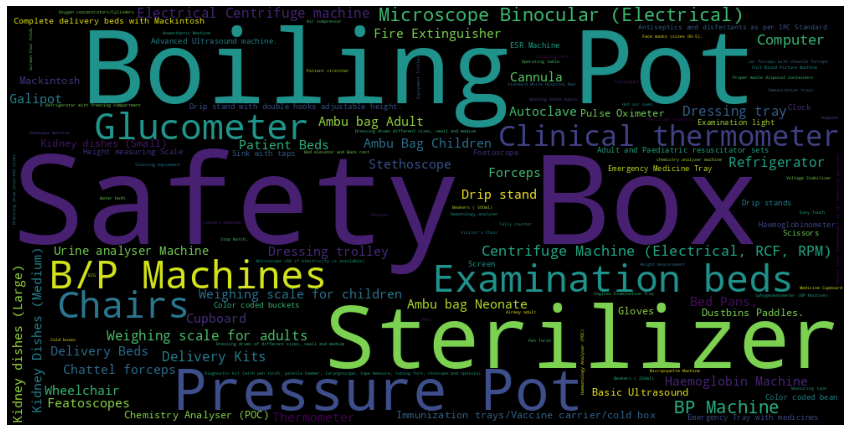

In [66]:
word_could_dict = Counter(equipment_df['Equipment Description'].values)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

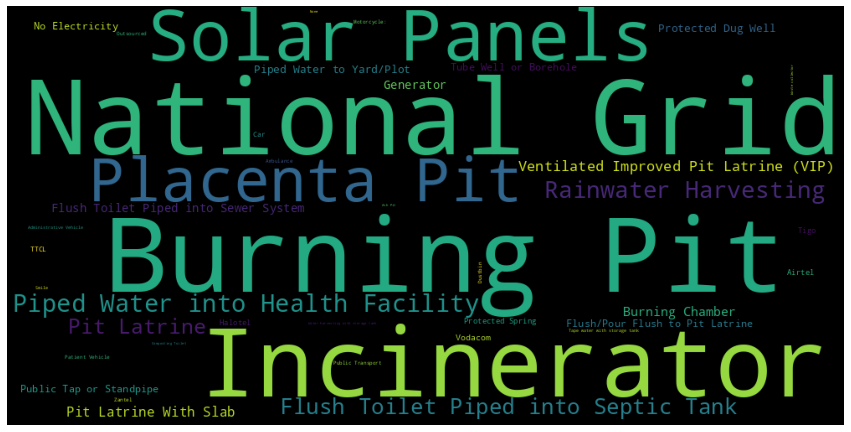

In [71]:
word_could_dict = Counter(infrastructure_df['Infrastructure Description'].values)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

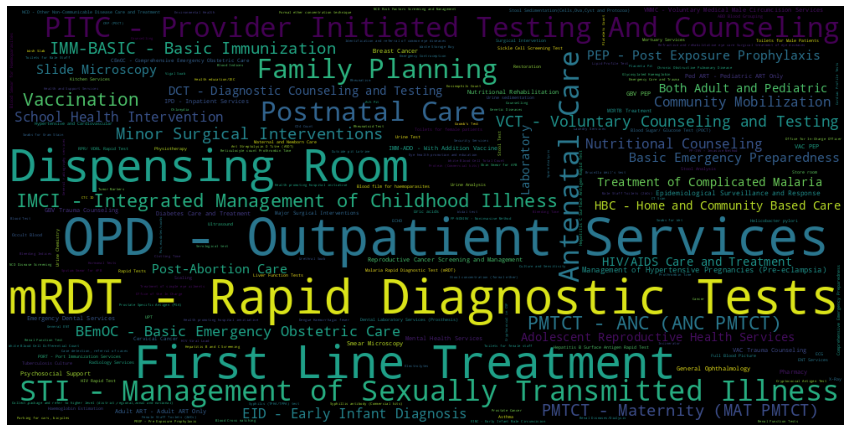

In [73]:
word_could_dict = Counter(service_offered_df['Service Description'].values)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [111]:
def get_lat_for_facility_id(facility_id):
    return facility_to_lat_lon[facility_id]['lat']
def get_lon_for_facility_id(facility_id):
    return facility_to_lat_lon[facility_id]['lon']
def get_type_for_facility_id(facility_id):
    return facility_to_lat_lon[facility_id]['type']
    
equipment_df['lat']  = equipment_df['facility_id'].apply(get_lat_for_facility_id)
equipment_df['lon']  = equipment_df['facility_id'].apply(get_lon_for_facility_id)
equipment_df['type'] = equipment_df['facility_id'].apply(get_type_for_facility_id)

equipment_gdf = geopandas.GeoDataFrame(
    equipment_df, geometry=geopandas.points_from_xy(equipment_df.lon, equipment_df.lat))

# Get spatial resoltion

In [ ]:
gdf = geopandas.read_postgis("SELECT * FROM shape WHERE type='district'", get_engine(), geom_col='geometry')

In [178]:
regions_gdf = geopandas.read_postgis("SELECT * FROM shape WHERE type='region'", get_engine(), geom_col='geometry')

# Patien Beds

In [154]:
beds_gdf = equipment_gdf[equipment_gdf['Equipment Description'] == 'Patient Beds']

Text(0.5, 1.0, 'Facilites with set Patien Beds')

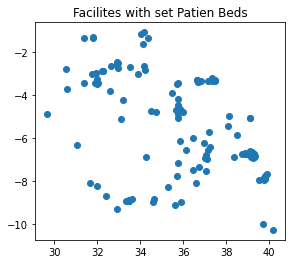

In [155]:
beds_gdf.plot()
plt.title('Facilites with set Patien Beds')

In [156]:
beds_gdf['type'].value_counts(dropna=False).rename_axis('type').reset_index(name='counts')

,type,counts
0,Dispensary,71
1,Health Center,35
2,PolyClinic,14
3,Hospital at District Level,6
4,Specialized Polyclinic,4
5,Hospital at Regional Level,2
6,Hospital at Zonal Level,2
7,Physiotherapy Clinic,1
8,Specialised Clinic,1
9,District Hospital,1


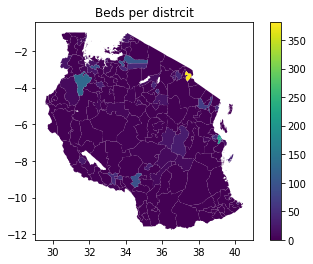

In [180]:
def count_beds_for_shape(geometry):
    tmp_gdf = beds_gdf[beds_gdf['geometry'].within(geometry)]
    return tmp_gdf['Total'].sum()

gdf['count'] = gdf['geometry'].apply(count_beds_for_shape)

gdf.plot(column='count', legend=True)
plt.title('Beds per distrcit')
plt.show()

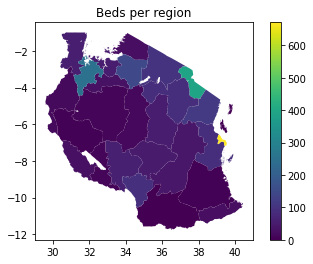

In [182]:
regions_gdf['count'] = regions_gdf['geometry'].apply(count_beds_for_shape)

regions_gdf.plot(column='count', legend=True)
plt.title('Beds per region')
plt.show()

# Macs

In [158]:
macs_gdf = equipment_gdf[equipment_gdf['Equipment Description'] == 'Mackintosh']

Text(0.5, 1.0, 'Facilites with set Patien Beds')

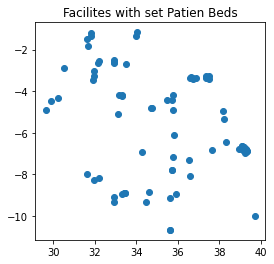

In [160]:
macs_gdf.plot()
plt.title('Facilites with set Patien Beds')

In [164]:
macs_gdf['type'].value_counts(dropna=False).rename_axis('type').reset_index(name='counts')

,type,counts
0,Dispensary,42
1,PolyClinic,17
2,Health Center,15
3,Hospital at District Level,5
4,Hospital at Regional Level,3
5,Specialized Polyclinic,3
6,Specialised Clinic,1
7,Dialysis Clinic,1
8,General Clinic,1
9,District Hospital,1


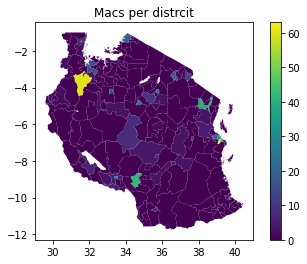

In [171]:
def count_macs_for_shape(geometry):
    tmp_gdf = macs_gdf[macs_gdf['geometry'].within(geometry)]
    return tmp_gdf['Total'].sum()


gdf['count'] = gdf['geometry'].apply(count_macs_for_shape)

gdf.plot(column='count', legend=True)
plt.title('Macs per distrcit')
plt.show()

# Visitors waiting

In [172]:
waiting_gdf = equipment_gdf[equipment_gdf['Equipment Description'] == 'Visitors waiting']

In [177]:
waiting_gdf

,index,Equipment Description,Functional,Non Functional,Under Maintanance,Total,facility_id,lat,lon,geometry,type
1328,66,Visitors waiting,2,0,0,2,14650,-8.939614,33.333141,POINT (33.33314 -8.93961),Dispensary
2248,18,Visitors waiting,10,0,0,10,14408,-2.514079,32.907901,POINT (32.90790 -2.51408),Specialized Polyclinic
2851,20,Visitors waiting,1,0,0,1,8941,-6.549860,36.127780,POINT (36.12778 -6.54986),Health Center
2976,2,Visitors waiting,6,0,0,6,15117,-6.910340,34.269770,POINT (34.26977 -6.91034),PolyClinic
3194,56,Visitors waiting,1,0,0,1,11776,-2.643110,34.162880,POINT (34.16288 -2.64311),Hospital at District Level
4574,41,Visitors waiting,1,0,0,1,13758,-9.604250,33.871361,POINT (33.87136 -9.60425),Comprehensive Dental Clinic
4719,45,Visitors waiting,3,0,0,3,1546,-6.826667,39.264248,POINT (39.26425 -6.82667),Specialized Polyclinic
6816,60,Visitors waiting,1,0,0,1,2567,-6.827550,39.257220,POINT (39.25722 -6.82755),Basic Dental Clinic
7012,138,Visitors waiting,1,0,0,1,2558,-3.315710,36.638800,POINT (36.63880 -3.31571),Dispensary
7969,42,Visitors waiting,1,0,0,1,13726,-6.877300,39.292000,POINT (39.29200 -6.87730),PolyClinic


Text(0.5, 1.0, 'Facilites with set Patien Beds')

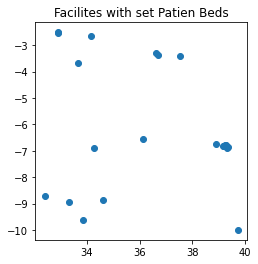

In [174]:
waiting_gdf.plot()
plt.title('Facilites with set Patien Beds')

In [175]:
waiting_gdf['type'].value_counts(dropna=False).rename_axis('type').reset_index(name='counts')

,type,counts
0,PolyClinic,9
1,Dispensary,7
2,Health Center,3
3,Specialized Polyclinic,2
4,Hospital at District Level,2
5,Comprehensive Dental Clinic,1
6,Basic Dental Clinic,1


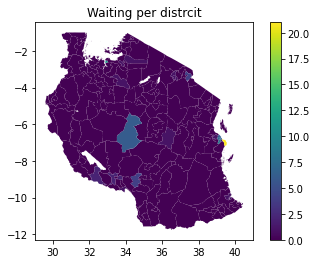

In [176]:
def count_waits_for_shape(geometry):
    tmp_gdf = waiting_gdf[waiting_gdf['geometry'].within(geometry)]
    return tmp_gdf['Total'].sum()


gdf['count'] = gdf['geometry'].apply(count_waits_for_shape)

gdf.plot(column='count', legend=True)
plt.title('Waiting per distrcit')
plt.show()